In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_temp = calc_temps('2016-08-01', '2016-08-07')
year_temp

[(72.0, 77.79545454545455, 83.0)]

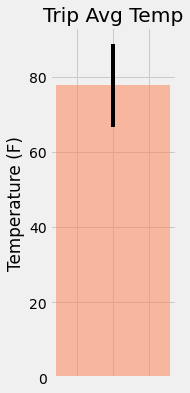

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = (year_temp[0])[1]
yerr = ((year_temp[0])[2])-((year_temp[0])[0])

fig, ax1 = plt.subplots(figsize =(2,6))
ax1.set_title('Trip Avg Temp')
ax1.set_ylabel('Temperature (F)')
ax1.bar(x = 1, height = y, yerr = yerr, color = "coral", alpha = 0.5)
ax1.set_xticklabels([])
plt.show()

### Daily Rainfall Average

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Measurement.date, Measurement.prcp, Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    join(Measurement, Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-08-01').filter(Measurement.date <= '2016-08-07').\
    group_by(Measurement.station).group_by(Measurement.date).\
    order_by(Measurement.prcp.desc()).all()


year_precip = pd.DataFrame(results, columns = ["Date", "Precipitation", "Station", "Station Name", "Latitude", "Longitude", "Elevation"])

year_precip


,Date,Precipitation,Station,Station Name,Latitude,Longitude,Elevation
0,2016-08-01,3.53,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,2016-08-01,2.35,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,2016-08-01,2.21,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,2016-08-07,1.30,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,2016-08-02,1.14,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
5,2016-08-02,0.83,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
6,2016-08-04,0.77,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,2016-08-04,0.62,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
8,2016-08-02,0.55,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
9,2016-08-01,0.54,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


### Daily Temperature Normals

In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session